In [12]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import networkx as nx
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image

In [13]:
def scan_folder_to_dataframe(base_folder):
    # List to store file paths and labels
    data = []

    # Walk through all subfolders and files in the base folder
    for root, dirs, files in os.walk(base_folder):
        for file in files:
            # Get full file path
            file_path = os.path.join(root, file)
            # Get the label (folder name)
            label = os.path.basename(root)
            # Append file path and label to the data list
            data.append((file_path, label))

    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['FilePath', 'Label'])
    return df

def create_and_split_dataset(base_folder, test_size=0.2):
    # Create dataset
    dataset = scan_folder_to_dataframe(base_folder)

    # Split the dataset into training and testing sets
    train_set, test_set = train_test_split(dataset, test_size=test_size, stratify=dataset['Label'], random_state=42)

    return train_set, test_set

In [14]:
def view_images_from_dataframe(df, num_images=5):
    """Display a few images from the DataFrame."""
    for index, row in df.head(num_images).iterrows():
        img = cv2.imread(row['FilePath'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Label: {row['Label']}")
        plt.axis('off')
        plt.show()


In [15]:
def extract_features_and_build_graph(df):
    """Extract features from images using ResNet and build a graph where edges represent feature similarities."""
    # Load the pre-trained ResNet model
    model = resnet50(pretrained=True)
    model.eval()  # Set the model to evaluation mode

    # Transformation pipeline for the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    G = nx.Graph()

    for index, row in df.iterrows():
        # Load and preprocess the image
        image = Image.open(row['FilePath']).convert('RGB')
        input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

        # Extract features using ResNet
        with torch.no_grad():
            features = model(input_tensor)

        # Flatten the features
        features = features.squeeze().numpy()

        # Add the node to the graph with features
        G.add_node(index, label=row['Label'], features=features)

    # Add edges based on feature similarity (cosine similarity)
    nodes = list(G.nodes(data=True))
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            node_i, data_i = nodes[i]
            node_j, data_j = nodes[j]

            # Compute cosine similarity
            features_i = data_i['features']
            features_j = data_j['features']
            similarity = (features_i @ features_j) / (np.linalg.norm(features_i) * np.linalg.norm(features_j))

            # Add an edge if similarity is above a threshold
            if similarity > 0.5:  # Adjust the threshold as needed
                G.add_edge(node_i, node_j, weight=similarity)

    return G

Training Set:
                                        FilePath     Label
5497       lung_image_sets\lung_n\lungn1446.jpeg    lung_n
12677  lung_image_sets\lung_scc\lungscc3408.jpeg  lung_scc
8037       lung_image_sets\lung_n\lungn3732.jpeg    lung_n
6670       lung_image_sets\lung_n\lungn2501.jpeg    lung_n
79      lung_image_sets\lung_aca\lungaca107.jpeg  lung_aca
...                                          ...       ...
5013        lung_image_sets\lung_n\lungn101.jpeg    lung_n
4721    lung_image_sets\lung_aca\lungaca748.jpeg  lung_aca
4788    lung_image_sets\lung_aca\lungaca808.jpeg  lung_aca
11253  lung_image_sets\lung_scc\lungscc2126.jpeg  lung_scc
7635       lung_image_sets\lung_n\lungn3370.jpeg    lung_n

[12000 rows x 2 columns]

Testing Set:
                                        FilePath     Label
6735       lung_image_sets\lung_n\lungn2560.jpeg    lung_n
4341   lung_image_sets\lung_aca\lungaca4906.jpeg  lung_aca
1852   lung_image_sets\lung_aca\lungaca2666.jpeg  lung_aca
30

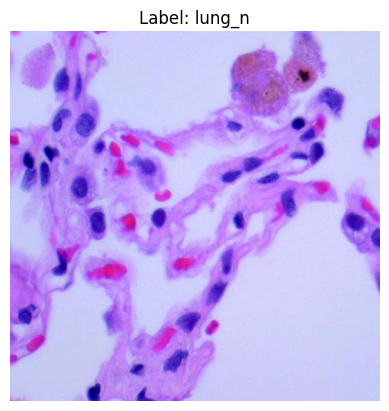

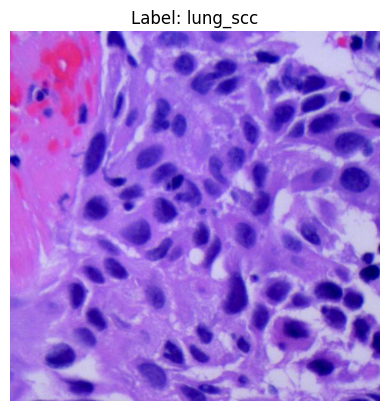

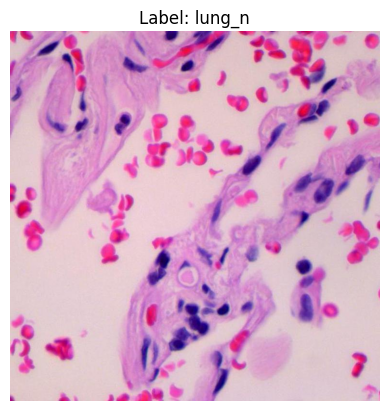

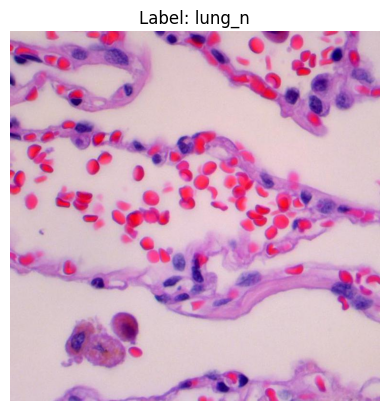

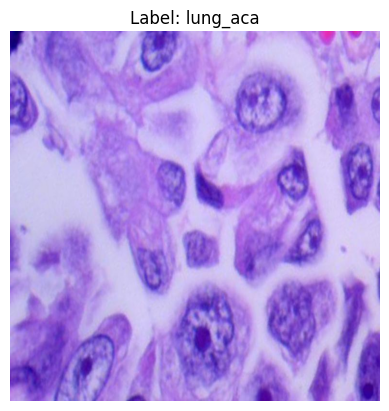

c:\Users\aydhi\OneDrive\Documents\capstone\TRY2\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aydhi\OneDrive\Documents\capstone\TRY2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\aydhi/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


KeyboardInterrupt: 

In [16]:
if __name__ == "__main__":
    base_folder = "lung_image_sets"  # Replace with your base folder path

    try:
        # Create and split the dataset
        

        print("Training Set:")
        print(train_set)

        print("\nTesting Set:")
        print(test_set)

        # View some images from the training set
        view_images_from_dataframe(train_set)

        # Build a graph from the training set
        graph = extract_features_and_build_graph(train_set)
        print(f"Graph has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")

    except ValueError as e:
        print(f"Error: {e}")